<a href="https://colab.research.google.com/github/salexey1990/gb/blob/master/cv/cv01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import imageio

При помощи numpy попробуем прибавить резкости случайному изображению. Моя идея состоит из нескольких шагов. Во-первых преобразуем цветное изображения в изображение оттенков серого, затем при помощи фильтров свёртки найдём горизонтальные и вертикальные паттерны, и путём их сложения найдём границы объектов. Затем преобразуем изображение к hsv цветовому пространству, и найденные на предыдущем этапе границы используем в качестве маски для увеличения яркости и насыщенности изображения на его границах.

In [2]:
# Загрузим изображение и приведём его индексы к типу float в диапазоне от 0 до 1
img = imageio.imread('city.jpeg')
img = img.astype(np.float32) / 255.
print(img.shape)

(470, 835, 3)


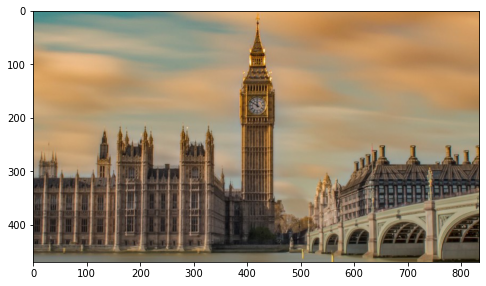

In [3]:
# Просмотр изображения
plt.figure(figsize=(8, 8))
plt.imshow(img)

Далее объявим несколько вспомогательных функций

In [0]:
# перевод из цветового пространства rgb в цветовое пространство hsv
def rgb2hsv(rgb):
    out = np.empty_like(rgb)

    # -- V channel
    out_v = rgb.max(-1)

    # -- S channel
    delta = rgb.ptp(-1)
    # Ignore warning for zero divided by zero
    old_settings = np.seterr(invalid='ignore')
    out_s = delta / out_v
    out_s[delta == 0.] = 0.

    # -- H channel
    # red is max
    idx = (rgb[..., 0] == out_v)
    out[idx, 0] = (rgb[idx, 1] - rgb[idx, 2]) / delta[idx]

    # green is max
    idx = (rgb[..., 1] == out_v)
    out[idx, 0] = 2. + (rgb[idx, 2] - rgb[idx, 0]) / delta[idx]

    # blue is max
    idx = (rgb[..., 2] == out_v)
    out[idx, 0] = 4. + (rgb[idx, 0] - rgb[idx, 1]) / delta[idx]
    out_h = (out[..., 0] / 6.) % 1.
    out_h[delta == 0.] = 0.

    np.seterr(**old_settings)

    # -- output
    out[..., 0] = out_h
    out[..., 1] = out_s
    out[..., 2] = out_v

    # # remove NaN
    out[np.isnan(out)] = 0

    return out

In [0]:
# перевод из цветового пространства hsv в цветовое пространство rgb
def hsv2rgb(hsv):
    hi = np.floor(hsv[..., 0] * 6)
    f = hsv[..., 0] * 6 - hi
    p = hsv[..., 2] * (1 - hsv[..., 1])
    q = hsv[..., 2] * (1 - f * hsv[..., 1])
    t = hsv[..., 2] * (1 - (1 - f) * hsv[..., 1])
    v = hsv[..., 2]

    hi = np.stack([hi, hi, hi], axis=-1).astype(np.uint8) % 6
    out = np.choose(hi, [np.stack((v, t, p), axis=-1),
                         np.stack((q, v, p), axis=-1),
                         np.stack((p, v, t), axis=-1),
                         np.stack((p, q, v), axis=-1),
                         np.stack((t, p, v), axis=-1),
                         np.stack((v, p, q), axis=-1)])

    return out

In [0]:
# Обработка изображения свёрточным фильтром
def conv(img, axis=0):
  w = np.array([
                [3.,10.,3.],
                [0.,0.,0.],
                [-3.,-10.,-3.]
  ]) if axis else np.array([
              [3.,0.,-3.],
              [10.,0.,-10.],
              [3.,0.,-3.]
  ])
  out_img = np.zeros(
      (img.shape[0],
      img.shape[1]), 
      dtype=np.float32)
  
  # для сохранения исходного размера изображения создадим рамку шириной 1 пиксель

  img = np.pad(img, (1,), 'minimum')

  for i in range(out_img.shape[0]):
      for j in range(out_img.shape[1]):
          x = img[i:i+w.shape[0], j:j+w.shape[1]]

          out_img[i,j] = np.sum(w * x)
  return out_img

Сперва преобразуем цветное изображение в оттенки серого и найдём границы объектов на нём

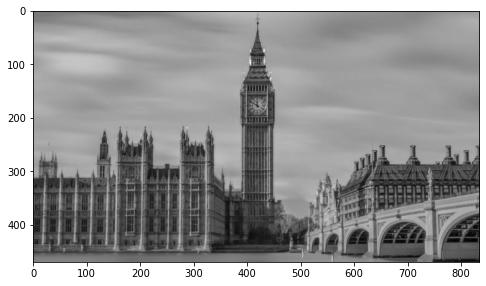

In [7]:
# Приведём изображение к оттенкам серого и посмотрим что получилось
img_bw = np.mean(img, axis=2)
plt.figure(figsize=(8, 8))
plt.imshow(img_bw, cmap='gray')

In [0]:
# При помощи двух свёрток по разным осям и последующем сложении результатов найдём границы изображений.

out_img_v = conv(img_bw, axis=0)
out_img_h = conv(img_bw, axis=1)
out_img = out_img_h + out_img_v

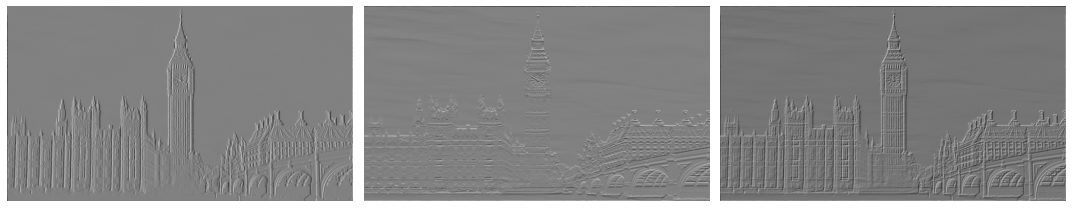

In [9]:
# Посмотрим что получилось
fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True,
                         figsize=(15, 4))

axes[0].imshow(out_img_v, cmap=plt.cm.gray)

axes[1].imshow(out_img_h, cmap=plt.cm.gray)

axes[2].imshow(out_img, cmap=plt.cm.gray)

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

Приведём исходное изображение к цветовому пространству hsv и добавим яркости границам объектов

In [0]:
hsv_img = rgb2hsv(img)

In [0]:
# Поэлементно сложим 2 координату пространства hsv, отвечающую за яркость изображения с маской, полученной на предыдущем этапе

img_hsv_new = np.copy(hsv_img)
img_hsv_new[:, :, 2] +=out_img
img_new = hsv2rgb(img_hsv_new)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


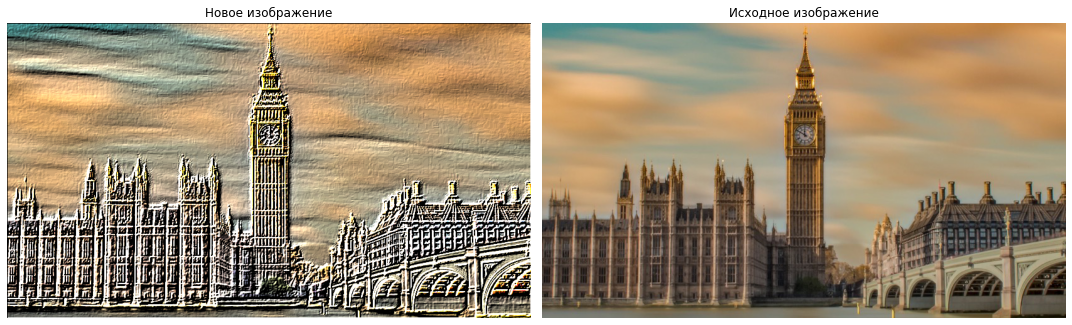

In [12]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True,
                         figsize=(15, 6))

axes[0].imshow(img_new, cmap=plt.cm.gray)
axes[0].set_title('Новое изображение')

axes[1].imshow(img, cmap=plt.cm.gray)
axes[1].set_title('Исходное изображение')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

Попробуем наложить маску на координату "насыщенности" в цветовом пространстве hsv

In [0]:
# Поэлементно сложим 1 координату пространства hsv, отвечающую за насыщенность изображения с маской, полученной на предыдущем этапе

img_hsv_new_2 = np.copy(hsv_img)
img_hsv_new_2[:, :, 1] +=out_img
img_new_2 = hsv2rgb(img_hsv_new_2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


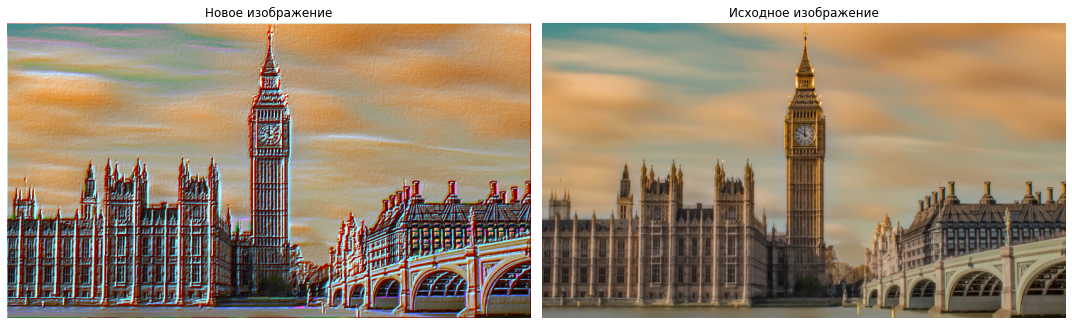

In [14]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True,
                         figsize=(15, 6))

axes[0].imshow(img_new_2, cmap=plt.cm.gray)
axes[0].set_title('Новое изображение')

axes[1].imshow(img, cmap=plt.cm.gray)
axes[1].set_title('Исходное изображение')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

Получилось немного странно, похоже, яркостью можно добиться лучшей резкости. Теперь применим веса для того, чтобы слегка снизить резкость

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


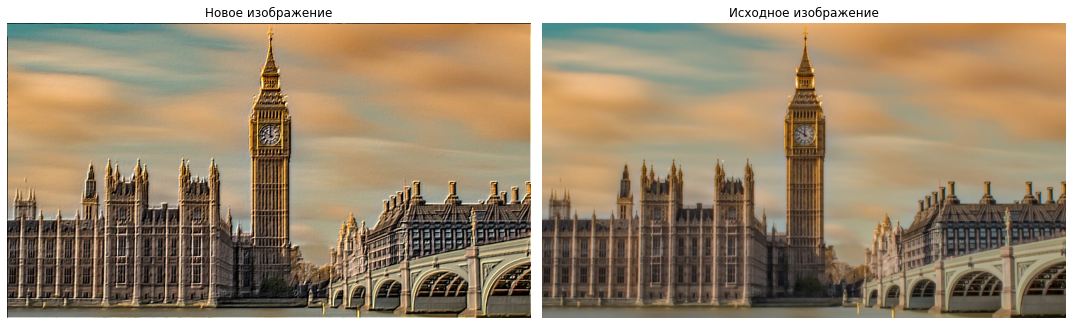

In [15]:
img_hsv_new_3 = np.copy(hsv_img)
img_hsv_new_3[:, :, 2] +=0.1*out_img
img_new_3 = hsv2rgb(img_hsv_new_3)

fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True,
                         figsize=(15, 6))

axes[0].imshow(img_new_3, cmap=plt.cm.gray)
axes[0].set_title('Новое изображение')

axes[1].imshow(img, cmap=plt.cm.gray)
axes[1].set_title('Исходное изображение')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()